In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.grid_search import ParameterGrid
from sklearn import ensemble 
from sklearn import neighbors
import seaborn as sns
sns.set()
import ml_pipeline2
from ml_pipeline2 import *
from sklearn import linear_model
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn import metrics
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn import svm
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_fscore_support, precision_recall_curve
from sklearn import ensemble 
from sklearn import neighbors
%load_ext autoreload
%autoreload 2 


/Users/quinnunderriner/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/Users/quinnunderriner/anaconda3/lib/python3.7/site-packages/sklearn/grid_search.py:14: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, namedtuple, Sized
/Users/quinnunderriner/anaconda3/lib/python3.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed i

In [71]:
MODELS = {
    'decision_tree': tree.DecisionTreeClassifier(),
    'logistic_regression': linear_model.LogisticRegression(), 
    'knn': neighbors.KNeighborsClassifier(),
    'random_forest': ensemble.RandomForestClassifier(), 
    'support_vector_machine': svm.SVC(), 
    'boosting': ensemble.AdaBoostClassifier(),
    'bagging': ensemble.BaggingClassifier()
}


PARAMS = {
    'decision_tree': {'max_depth': [5, 8, 20]},
    'logistic_regression': {'C': [0.001,0.01,0.1,1,10]}, 
    'knn': {'n_neighbors': [5, 10, 25] },
    'random_forest': {'n_estimators': [1, 10, 25, 50]}, 
    'support_vector_machine': {'c_values': [10**-2, 10**-1, 1 , 10, 10**2]}, 
    'boosting': {'n_estimators': [100, 50, 30]},
    'bagging': {'n_estimators': [2, 10, 20]} 
}

In [2]:
### Load Data 
filename = "projects_2012_2013.csv"
data = ml_pipeline2.load_data(filename)

In [ ]:
### Clean data 

In [3]:
#figure out which columns have missing values
#because students_reached is the only noncategorial data missing, only imputing median values
#for this column and deleting rows with missing data from the others. 
data.columns[data.isna().any()].tolist()
ml_pipeline2.impute_median(data, median_cols=["students_reached"])#needs to be run before discretized 
data = data.dropna()

In [4]:
#drop values that wont be needed for prediction. Dropping location values here even though they likley
#would help prediction because policy wise, we can't reconmond that schools move
data = data.drop(['projectid', 'teacher_acctid', 'schoolid', 'school_ncesid',
       'school_latitude', 'school_longitude', 'school_city', 'school_state',
       'school_metro', 'school_county', "school_district"], axis=1)



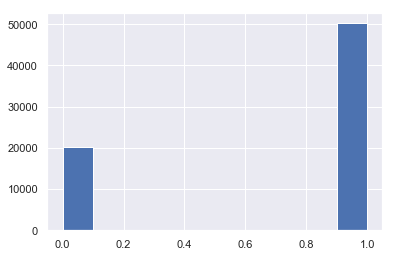

In [7]:
### Create predictor variables. assign a value of 1 if a project was funded within 60 days, a 
#value of zero if not
data['date_posted'] = pd.to_datetime(data['date_posted'], format='%m/%d/%y')
data['datefullyfunded'] = pd.to_datetime(data['datefullyfunded'], format='%m/%d/%y')
start_date = '2011-01-01'
end = '2013-12-31'
data["days_2_fund"] = data['datefullyfunded'] - data['date_posted']
data["days_2_fund"] = data["days_2_fund"].dt.days
data['predvar'] = np.where(data['days_2_fund']<= 60, 1, 0)
data['predvar'].hist()

In [6]:
#Three columns (eligible_double_your_impact_match', 'school_charter', 'school_magnet) have true/false values, currently replacing
#them with 1 for true
data = data.replace({"t": 1, "f": 0})

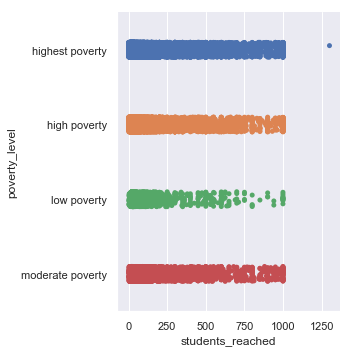

In [43]:
#see relationship between poverty and how many students are affected
sns.catplot(x="students_reached", y="poverty_level", data=data)

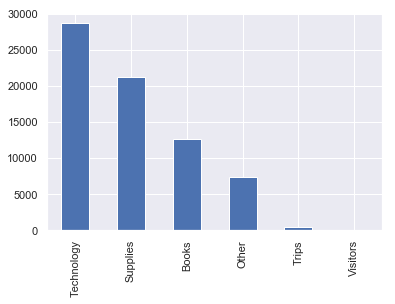

In [106]:
# Technology is the most common ask for funding 
data['resource_type'].value_counts().plot(kind='bar')

In [8]:
#make dummy variables for categorical variables

dummiez = ["teacher_prefix","primary_focus_area","secondary_focus_area","primary_focus_subject","secondary_focus_subject","resource_type","poverty_level","grade_level"]

for i in dummiez:
    data = ml_pipeline2.dummy(data, i)

In [10]:
#discrtize continous variables
data = ml_pipeline2.discretize(data, "students_reached")
data = ml_pipeline2.discretize(data, "total_price_including_optional_support")

In [42]:
### get descriptive statististics for each column 
ml_pipeline2.describe_cols(data)

count    70502.000000
mean         0.049374
std          0.216650
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: school_charter, dtype: float64
count    70502.00000
mean         0.09821
std          0.29760
min          0.00000
25%          0.00000
50%          0.00000
75%          0.00000
max          1.00000
Name: school_magnet, dtype: float64
count     70502
unique        4
top           1
freq      17627
Name: total_price_including_optional_support, dtype: int64
count     70502
unique        4
top           1
freq      18762
Name: students_reached, dtype: int64
count    70502.000000
mean         0.312431
std          0.463488
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: eligible_double_your_impact_match, dtype: float64
count                   70502
unique                    730
top       2013-09-03 00:00:00
freq                      422
first  

count    70502.000000
mean         0.021092
std          0.143691
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: secondary_focus_subject_College & Career Prep, dtype: float64
count    70502.000000
mean         0.006028
std          0.077408
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: secondary_focus_subject_Community Service, dtype: float64
count    70502.000000
mean         0.057927
std          0.233608
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: secondary_focus_subject_ESL, dtype: float64
count    70502.000000
mean         0.042595
std          0.201943
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: secondary_focus_subject_Early Development, dtype: float64
count    70502.000000
mean         0.005262
std   

In [47]:
#percent of projects that are fully funded in 60 days
data.predvar.sum() / data.predvar.count()

0.7126890017304474

In [ ]:
### Create predictor variables. assign a value of 1 if a project was funded within 60 days, a 
#value of zero if not

In [13]:
response = "predvar"
features = [x for x in data.columns if x not in [ 'projectid', 'date_posted', 'datefullyfunded','predvar', 'days_2_fund']]

In [35]:
# feature selection with random forest (from https://towardsdatascience.com/feature-selection-using-random-forest-26d7b747597f)

X,y = get_xy(data, response, features)

sel = sklearn.feature_selection.SelectFromModel(sklearn.ensemble.RandomForestClassifier(n_estimators = 100))
sel.fit(X, y)

chosen_features = data[features].columns[sel.get_support()]

In [74]:
# leave out slow models for now (and for analysis)
df = run_the_models(data, ['boosting',
                           'bagging', 
                           'random_forest', 
                           'decision_tree', 
                           'logistic_regression'], response, chosen_features)

In [75]:
#output 
df

,model,parameters,train_start,train_end,test_start,test_end,f1_score,auc,precision_at_0.01,precision_at_0.02,...,precision_at_0.2,precision_at_0.3,precision_at_0.5,recall_at_0.01,recall_at_0.02,recall_at_0.05,recall_at_0.1,recall_at_0.2,recall_at_0.3,recall_at_0.5
0,boosting,{'n_estimators': 100},2012-01-01,2012-07-31,2012-07-31,2013-01-31,0.526223,0.839679,0.743580,0.743580,...,0.743580,0.743580,0.754293,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.946864
1,boosting,{'n_estimators': 50},2012-01-01,2012-07-31,2012-07-31,2013-01-31,0.527074,0.839424,0.743580,0.743580,...,0.743580,0.743580,0.754661,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.945638
2,boosting,{'n_estimators': 30},2012-01-01,2012-07-31,2012-07-31,2013-01-31,0.525520,0.840971,0.743580,0.743580,...,0.743580,0.743580,0.753960,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.950685
3,bagging,{'n_estimators': 2},2012-01-01,2012-07-31,2012-07-31,2013-01-31,0.549519,0.694133,0.750940,0.750940,...,0.752682,0.757119,0.774884,0.907138,0.907138,0.907138,0.903317,0.885148,0.862581,0.628623
4,bagging,{'n_estimators': 10},2012-01-01,2012-07-31,2012-07-31,2013-01-31,0.548827,0.762587,0.744687,0.744765,...,0.750706,0.754649,0.769163,0.987743,0.987311,0.984138,0.967267,0.939005,0.895242,0.756020
5,bagging,{'n_estimators': 20},2012-01-01,2012-07-31,2012-07-31,2013-01-31,0.549282,0.770868,0.743981,0.743978,...,0.748779,0.752511,0.768806,0.993727,0.993079,0.987383,0.978515,0.950685,0.913050,0.772963
6,random_forest,{'n_estimators': 1},2012-01-01,2012-07-31,2012-07-31,2013-01-31,0.543602,0.729133,0.756424,0.756424,...,0.758428,0.759525,0.768346,0.802235,0.802235,0.802235,0.802235,0.791565,0.779019,0.693727
7,random_forest,{'n_estimators': 10},2012-01-01,2012-07-31,2012-07-31,2013-01-31,0.550857,0.773495,0.745102,0.745248,...,0.749929,0.753668,0.769423,0.989906,0.989402,0.987311,0.973540,0.950036,0.911031,0.777578
8,random_forest,{'n_estimators': 25},2012-01-01,2012-07-31,2012-07-31,2013-01-31,0.549819,0.781318,0.743754,0.743964,...,0.749326,0.752571,0.768277,0.995890,0.995314,0.991565,0.984571,0.961644,0.923432,0.794809
9,random_forest,{'n_estimators': 50},2012-01-01,2012-07-31,2012-07-31,2013-01-31,0.549899,0.784520,0.743577,0.744007,...,0.748389,0.753190,0.768099,0.997477,0.995746,0.992430,0.984283,0.962870,0.927614,0.801658


In [83]:
df.groupby(['model', 'parameters'])[['f1_score', 'auc', 'precision_at_0.5', 'recall_at_0.5']].mean().sort_values('f1_score', ascending=False)

f1_score       auc  \
model               parameters                                  
decision_tree       {'max_depth': 20}      0.545291  0.735545   
bagging             {'n_estimators': 2}    0.543900  0.711505   
random_forest       {'n_estimators': 1}    0.543246  0.732626   
bagging             {'n_estimators': 20}   0.542575  0.767744   
random_forest       {'n_estimators': 50}   0.542461  0.777961   
bagging             {'n_estimators': 10}   0.542415  0.762648   
random_forest       {'n_estimators': 25}   0.541519  0.774476   
                    {'n_estimators': 10}   0.540631  0.769060   
logistic_regression {'C': 10}              0.529895  0.824491   
                    {'C': 1}               0.529608  0.824747   
                    {'C': 0.1}             0.527655  0.826136   
decision_tree       {'max_depth': 5}       0.526763  0.819946   
                    {'max_depth': 8}       0.526611  0.819675   
boosting            {'n_estimators': 50}   0.521058  0.828013   
                    {'n_estimators': 100}  0.520604  0.828232   
                    {'n_estimators': 30}   0.519701  0.828618   
logistic_regression {'C': 0.01}            0.519186  0.828112   
                    {'C': 0.001}           0.503149  0.832748   

                                           precision_at_0.5  recall_at_0.5  
model               parameters                                              
decision_tree       {'max_depth': 20}              0.741371       0.732040  
bagging             {'n_estimators': 2}            0.742334       0.685972  
random_forest       {'n_estimators': 1}            0.740327       0.726616  
bagging             {'n_estimators': 20}           0.737493       0.802282  
random_forest       {'n_estimators': 50}           0.736741       0.825577  
bagging             {'n_estimators': 10}           0.737778       0.791192  
random_forest       {'n_estimators': 25}           0.736422       0.817991  
                    {'n_estimators': 10}           0.736179       0.806107  
logistic_regression {'C': 10}                      0.728237       0.952079  
                    {'C': 1}                       0.728099       0.952950  
                    {'C': 0.1}                     0.727174       0.958110  
decision_tree       {'max_depth': 5}               0.727110       0.944480  
                    {'max_depth': 8}               0.726935       0.941844  
boosting            {'n_estimators': 50}           0.724194       0.968303  
                    {'n_estimators': 100}          0.723993       0.969238  
                    {'n_estimators': 30}           0.723591       0.970933  
logistic_regression {'C': 0.01}                    0.723411       0.969820  
                    {'C': 0.001}                   0.716616       0.994514

In [ ]:
# now run slow models
df = run_the_models(data, ['boosting',
                           'bagging', 
                           'random_forest', 
                           'decision_tree', 
                           'logistic_regression',
                           'knn',
                           'support_vector_machine'], response, features)